In [1]:
# Imports
from os import listdir
from os.path import isfile, join
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import joblib

In [2]:
# Chargement des données
root_folder = "C:/Users/user/Downloads/SESA/data"

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # Mel-frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = mfccs.mean(axis=1)

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    
    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y).mean()
    
    # Spectral centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    
    # RMS energy
    rms = librosa.feature.rms(y=y).mean()

    return np.hstack([mfccs_mean, chroma_mean, zcr, centroid, rms])

In [3]:
# Train set
X_train = []
y_train = []
train_path = root_folder + '/' + 'train'
lof_train = [f for f in listdir(train_path)]
for file in lof_train:
    if file.lower().endswith('.wav'):
        wav_path = train_path + '/' + file
        #print(f"Processing {file}...")

        try:
            feats = extract_features(wav_path)
            X_train.append(feats)
            label = file.split("_")[0]
            y_train.append(label)
        except Exception as e:
            print(f"Erreur sur {fname}: {e}")

c:\Users\user\Downloads\SESA\.venv\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [4]:
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-214.139328,85.231926,7.754147,20.030664,8.435097,-1.148879,-1.674291,2.449226,-3.082518,-2.504000,...,0.478759,0.504952,0.534267,0.727406,0.788003,0.747385,0.654225,0.193532,2044.197727,0.051666
1,-182.669891,139.957489,-13.008949,-9.594439,2.268462,-8.228940,-3.368181,-3.799409,-6.904059,-3.342158,...,0.633659,0.536250,0.532729,0.568491,0.592439,0.599005,0.584748,0.085275,1247.551661,0.047365
2,-208.489929,153.425247,27.717066,-7.101077,3.268686,1.448832,-0.675364,0.723373,-2.197042,-5.230395,...,0.673747,0.581035,0.547317,0.520845,0.469584,0.455226,0.520902,0.047634,950.981297,0.064541
3,-144.941574,117.532486,-0.449676,17.386435,-2.250551,7.353186,-3.068521,3.168828,-1.312694,5.112125,...,0.725217,0.742954,0.678572,0.610537,0.563910,0.581578,0.555316,0.082538,1396.616828,0.081770
4,-193.035004,133.166901,21.552776,12.347239,10.635363,11.406835,0.431604,1.365485,-1.240355,1.622149,...,0.623323,0.621211,0.586411,0.558854,0.579070,0.592900,0.604336,0.051036,1100.243810,0.065801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-177.370667,58.329281,-16.320314,44.719917,-19.990864,-29.236916,4.663920,7.354265,-12.078789,-2.650355,...,0.227030,0.242504,0.330990,0.439732,0.406590,0.246047,0.219627,0.324108,2459.328518,0.069656
476,-127.919083,-2.386326,-100.990311,-10.497728,-39.396351,17.145721,10.154982,21.286140,-6.785413,15.749054,...,0.162540,0.181126,0.258063,0.440464,0.450998,0.282677,0.135753,0.272870,2498.663703,0.242133
477,-188.819656,54.939171,-25.648821,-0.949367,-16.657108,-5.479622,-9.296740,6.340583,7.877621,27.045076,...,0.927878,0.273858,0.120860,0.098622,0.100926,0.119737,0.126323,0.178836,2237.346796,0.065277
478,-248.646072,2.169747,-28.063004,-0.974340,-13.223262,0.105991,-8.894626,-2.588324,-6.156933,-1.077065,...,0.457760,0.203852,0.182820,0.263744,0.438497,0.709288,0.318479,0.391877,3260.698355,0.042513


In [5]:
len(y_train)

480

In [6]:
# Test set
X_test = []
y_test = []
test_path = root_folder + '/' + 'test'
lof_test = [f for f in listdir(test_path)]
for file in lof_test:
    if file.lower().endswith('.wav'):
        wav_path = test_path + '/' + file
        #print(f"Processing {file}...")

        try:
            feats = extract_features(wav_path)
            X_test.append(feats)
            label = file.split("_")[0]
            y_test.append(label)
        except Exception as e:
            print(f"Erreur sur {fname}: {e}")

c:\Users\user\Downloads\SESA\.venv\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [7]:
X_test = pd.DataFrame(X_test)
X_test

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-285.336853,39.557961,6.823731,-6.991809,-2.231251,-5.570866,4.142883,1.919463,2.996999,3.828701,...,0.569548,0.310014,0.390827,0.589161,0.561746,0.588151,0.524879,0.425364,3271.755106,0.036499
1,-202.148529,125.430786,22.815258,16.928595,7.827446,10.610357,1.928356,0.797735,-1.971050,-0.569811,...,0.569210,0.543528,0.513976,0.489720,0.502839,0.539857,0.543281,0.052478,1214.218380,0.065391
2,-274.326050,87.713692,22.296471,12.046974,9.290386,0.227976,-1.534712,-2.058927,0.810843,0.883053,...,0.645090,0.599804,0.539339,0.534313,0.535573,0.538027,0.602612,0.189355,2076.725711,0.032892
3,-139.558014,96.290459,-12.715135,23.884241,3.912950,9.122540,-1.091687,1.826365,-3.864039,2.160678,...,0.684887,0.716741,0.685434,0.644448,0.590593,0.658821,0.641076,0.117526,1706.186268,0.067358
4,-278.747559,104.703293,49.921154,30.906958,12.577966,8.418180,5.877398,7.357359,5.469634,5.562014,...,0.562819,0.576976,0.559009,0.578383,0.587534,0.572545,0.580519,0.026760,1219.496192,0.039894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-265.904297,52.246677,-68.882263,-55.843246,-15.972671,11.794717,31.168846,11.064370,-10.932279,-3.095665,...,0.336265,0.320221,0.195223,0.187935,0.281024,0.418418,0.461378,0.141331,1838.012219,0.027977
101,-141.827957,-4.415758,-15.064084,15.997670,-6.823156,4.078452,-23.603327,4.172225,-6.441214,27.220316,...,0.137512,0.233003,0.156298,0.406801,0.268735,0.812219,0.227465,0.529511,3709.316379,0.081658
102,-217.382385,34.357731,-21.979385,43.358074,-13.459932,-33.682705,10.395032,18.594257,-11.773409,-0.539092,...,0.257268,0.196952,0.287177,0.434506,0.417376,0.323774,0.194279,0.350868,2748.393164,0.078268
103,-218.826126,-4.936053,-60.218437,-20.703886,-19.971292,58.685089,-7.173977,-10.568643,6.391278,4.351566,...,0.350129,0.391317,0.428663,0.502217,0.507551,0.491538,0.412336,0.330203,2908.725252,0.389553


In [8]:
len(y_test)

105

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [10]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "SVM": SVC(kernel='rbf', probability=True, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    report = classification_report(y_val, y_pred, output_dict=True)

    results[name] = {
        "model": model,
        "report": report
    }

c:\Users\user\Downloads\SESA\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
for name, res in results.items():
    print(f"\n=== {name} ===")
    print(pd.DataFrame(res["report"]).T[["precision", "recall", "f1-score"]])


=== RandomForest ===
              precision    recall  f1-score
0              0.812500  0.928571  0.866667
1              0.903226  0.823529  0.861538
2              0.933333  0.875000  0.903226
3              0.888889  0.888889  0.888889
accuracy       0.875000  0.875000  0.875000
macro avg      0.884487  0.878997  0.880080
weighted avg   0.879094  0.875000  0.875110

=== LogisticRegression ===
              precision    recall  f1-score
0              0.648649  0.857143  0.738462
1              0.851852  0.676471  0.754098
2              0.882353  0.937500  0.909091
3              1.000000  0.833333  0.909091
accuracy       0.802083  0.802083  0.802083
macro avg      0.845713  0.826112  0.827685
weighted avg   0.825446  0.802083  0.804431

=== SVM ===
              precision    recall  f1-score
0              0.870968  0.964286  0.915254
1              0.909091  0.882353  0.895522
2              1.000000  0.875000  0.933333
3              1.000000  1.000000  1.000000
accuracy     

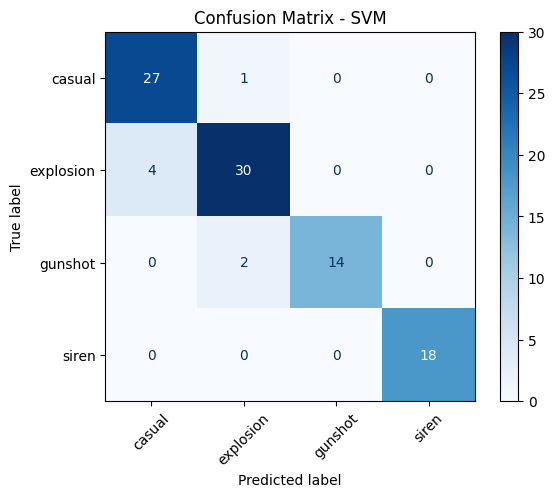

In [12]:
# Confusion matrix on validation set
from sklearn.metrics import ConfusionMatrixDisplay

best_model = results["SVM"]["model"]
y_pred = best_model.predict(X_val)
label_names = le.classes_

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=label_names, cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xticks(rotation=45)
plt.show()

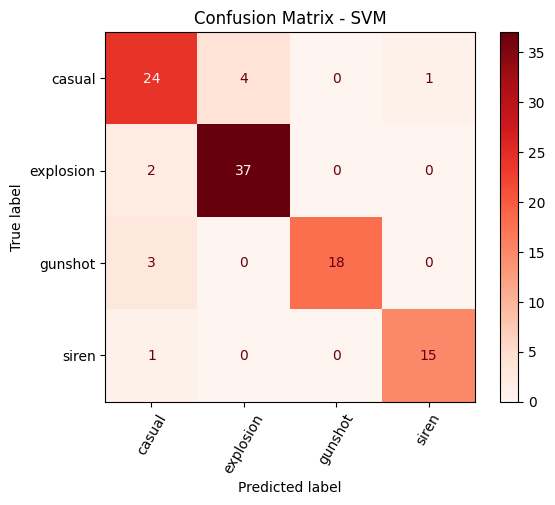

In [13]:
# Confusion matrix on test set
from sklearn.metrics import ConfusionMatrixDisplay

best_model = results["SVM"]["model"]
y_pred = best_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_names, cmap='Reds')
plt.title("Confusion Matrix - SVM")
plt.xticks(rotation=60)
plt.show()

In [14]:
joblib.dump(best_model, "best_multiclass_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
results = {}

# Isolation Forest
print("_____________________________")
print(" --  Isolation Forest -- ")
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train)
y_pred = iso.predict(X_val)
y_pred = np.where(y_pred == -1, 1, 0)
results["IsolationForest"] = {
    "report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc_score(y_val, y_pred)
}
print("_____________________________")
print("\n")

# One-Class SVM
print("_____________________________")
print(" --  One-Class SVM -- ")
svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
svm.fit(X_train)
y_pred = svm.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)
results["OneClassSVM"] = {
    "report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc_score(y_test, y_pred)
}
print("_____________________________")
print("\n")

# Local Outlier Factor (unsupervised, fit + predict sur test)
print("_____________________________")
print(" --  Isolation Forest -- ")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)
results["LOF"] = {
    "report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc_score(y_test, y_pred)
}
print("_____________________________")
print("\n")

# RandomForest (supervised, si labels fiables)
print("_____________________________")
print(" --  Isolation Forest -- ")
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results["RandomForest"] = {
    "report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc_score(y_test, y_pred)
}
print("_____________________________")
print("\n")